# Notebook - Análise da evasão

Dados do Instituto de Ciências Exatas (IE).

### Importando bibliotecas:

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

import utils
import process
import pre_process

%matplotlib inline

 ### Leitura dos dados

In [2]:
DATA_FILE = '../data/ie_data.csv'
data_pre = pd.read_csv(DATA_FILE, sep=';', low_memory=False)

## Pré-Processamento

In [3]:
attrs = []
data_pre = pre_process.format_data(data_pre)
data_pre = pre_process.erase_attr(data_pre)
data_pre = data_pre.dropna()

data_pre = pre_process.public_school(data_pre, attrs)
data_pre = pre_process.dropout(data_pre, attrs)
data_pre = pre_process.course(data_pre, attrs)
data_pre = pre_process.gender(data_pre, attrs)
data_pre = pre_process.quota(data_pre, attrs)
data_pre = pre_process.entry(data_pre, attrs)

data_pre = pre_process.cic_courses(data_pre)
data_pre = pre_process.erase_interal_transfer_students(data_pre)

horizon = 1  # 1 year = 2 semesters
data_pre = pre_process.beyond_horizon(data_pre, horizon)
credits_dict = pre_process.subject_credits(data_pre)

In [22]:
# Reload module
import importlib
importlib.reload(utils)

<module 'utils' from '/home/tiago/git/trj-academica/pipeline/utils.py'>

Divide dataframe by course:

In [4]:
data_course = pre_process.divide_course(data_pre)
data_course['all'] = data_pre

Remove course attribute from individual dataframes:

(Preciso remodelar o pipeline antes de retirar esse atributo)

In [ ]:
# for course in keys:
#     if course != 'all':
#         data_course[course].drop('course', axis=1, inplace=True)

### Process Subjects and CEP

The Subjects are processed for each course individually, and Cep needs to be processed before all other attributes and drop_duplicates, otherwise it takes too long to process.

In [5]:
keys = data_course.keys()
data_analysis = {}
for course in keys:
    print(course)
    data = data_course[course].copy()
    attrs_copy = attrs.copy()

    # Process subjects
    data = pre_process.add_semester_prefix(data)
    data = pre_process.subjects(data, attrs_copy, horizon, credits_dict)

    # Process CEP
    # It needs to be processed before drop_duplicates, or it takes too long to process.
    data = data[attrs_copy+['cep', 'aluno']].drop_duplicates()
    data = pre_process.cep(data, attrs_copy)

    data_analysis[course] = data.copy()  # make a copy for data analysis
    data = data[attrs_copy].drop_duplicates()
    data_course[course] = data.copy()

ciência da computação
computação
engenharia de computação
engenharia mecatrônica
all


In [6]:
data_process = data_course.copy()

## Analysis

Tamanho da base:

In [ ]:
# for course in data_course.keys():
#     print(f'{course} = {data_course[course].shape}')

Desbalanceamento da base:

In [ ]:
# for course in data_course.keys():
#     print(f'{course}:')
#     freq = data_course[course]['dropout'].value_counts()
#     print(freq)
#     print('\n')

## Testes

In [ ]:
# data_course['computação']['2_ira'].value_counts()

## Processamento

In [23]:
def catboost(data):
    output_attr = 'dropout'
    cat_attr = ['course', 'entry']

    X = data.drop(columns=[output_attr])
    y = data[output_attr]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # dropout imbalance
    output_freq = data[output_attr].value_counts()
    scale = output_freq[0] / output_freq[1]  # negative / positive

    model = CatBoostClassifier(scale_pos_weight=scale)
    model.fit(X_train, y_train, cat_features=cat_attr, plot=False, silent=True)

    process.show_metrics(model, X_train, y_train, X_test, y_test)
    # utils.precision_recall_graph(model, X_test, y_test)

    # shap importance
    shap_values = model.get_feature_importance(
        Pool(X_test, label=y_test, cat_features=cat_attr), 
        type="ShapValues"
    )
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=20) 

    # fi = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=cat_attr), type='LossFunctionChange')
    # utils.plot_feature_importance(fi, X.columns, 'Catboost')

    return model, X_test

Process all dataframes:


Curso = ciência da computação


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Treino:
Accuracy = 90.67%
Precision = 88.27%
Recall = 95.86%
FScore = 93.39%
Teste:
Accuracy = 80.12%
Precision = 76.95%
Recall = 91.48%
FScore = 86.46%


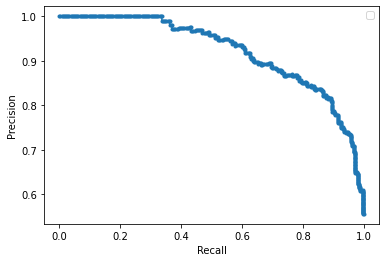

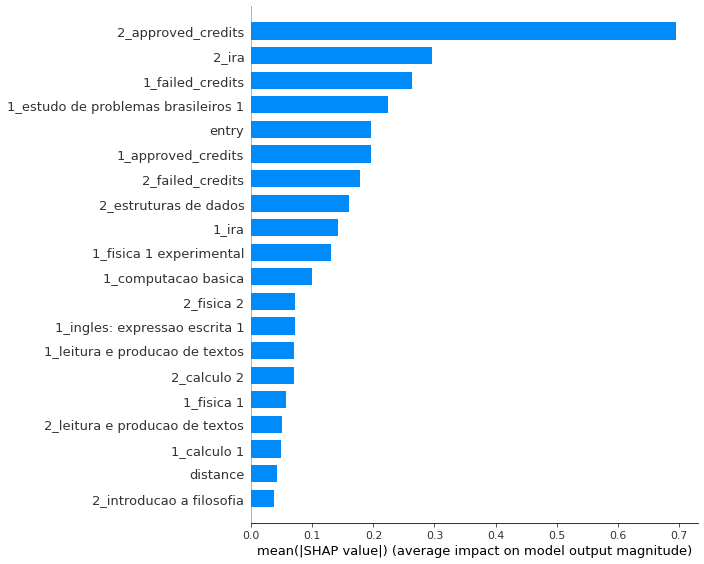


Curso = computação


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Treino:
Accuracy = 93.48%
Precision = 93.92%
Recall = 97.38%
FScore = 96.29%
Teste:
Accuracy = 78.80%
Precision = 81.19%
Recall = 92.50%
FScore = 88.70%


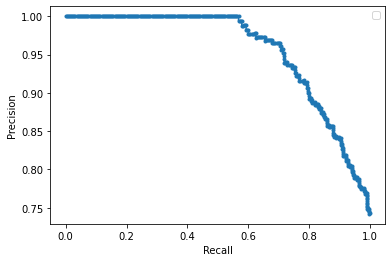

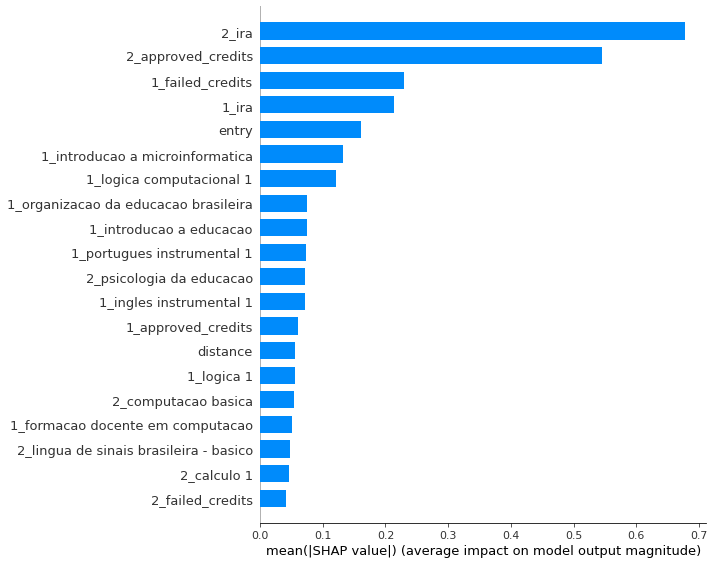


Curso = engenharia de computação


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Treino:
Accuracy = 90.62%
Precision = 88.77%
Recall = 98.00%
FScore = 94.96%
Teste:
Accuracy = 81.21%
Precision = 81.67%
Recall = 91.59%
FScore = 88.29%


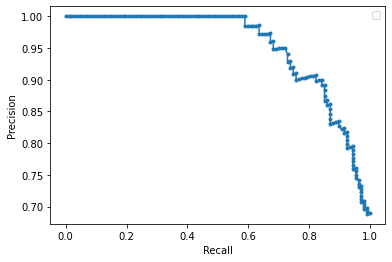

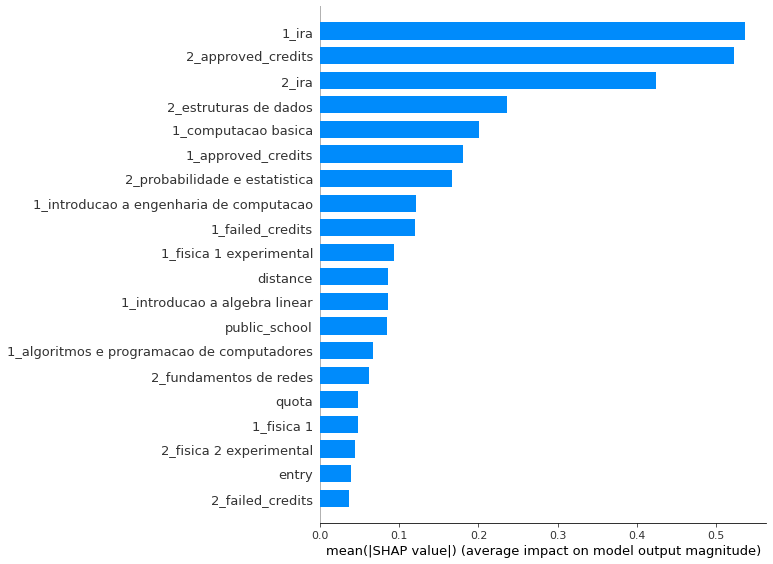


Curso = engenharia mecatrônica


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Treino:
Accuracy = 87.43%
Precision = 81.45%
Recall = 94.94%
FScore = 90.34%
Teste:
Accuracy = 75.93%
Precision = 70.72%
Recall = 83.66%
FScore = 79.20%


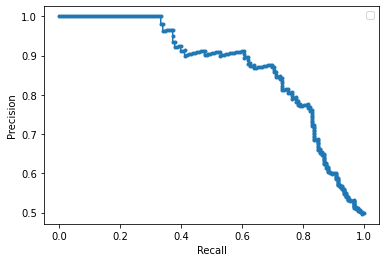

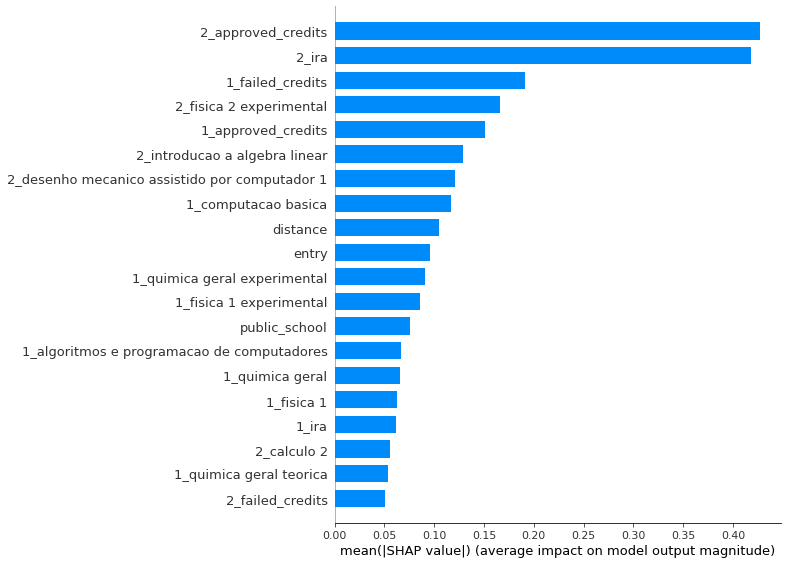


Curso = all


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Treino:
Accuracy = 89.10%
Precision = 88.93%
Recall = 93.32%
FScore = 91.92%
Teste:
Accuracy = 78.87%
Precision = 80.00%
Recall = 86.03%
FScore = 84.08%


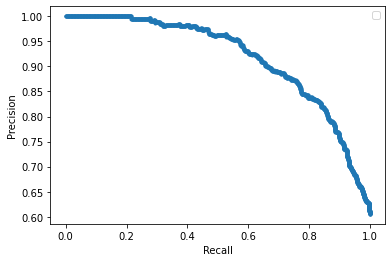

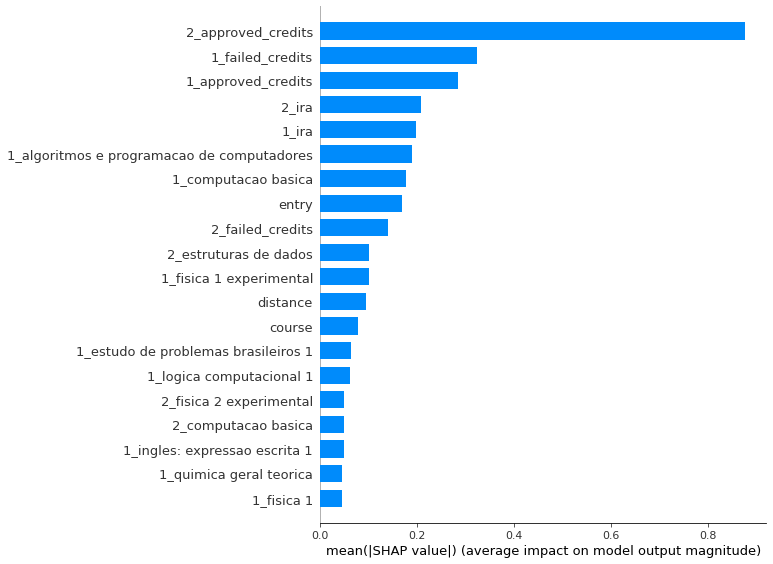

In [24]:
for course, data in data_process.items():
    print(f'\nCurso = {course}')
    model, X_test = catboost(data)

Process a single dataframe:

Treino:
Accuracy = 90.62%
Precision = 88.77%
Recall = 98.00%
FScore = 94.96%
Teste:
Accuracy = 81.21%
Precision = 81.67%
Recall = 91.59%
FScore = 88.29%


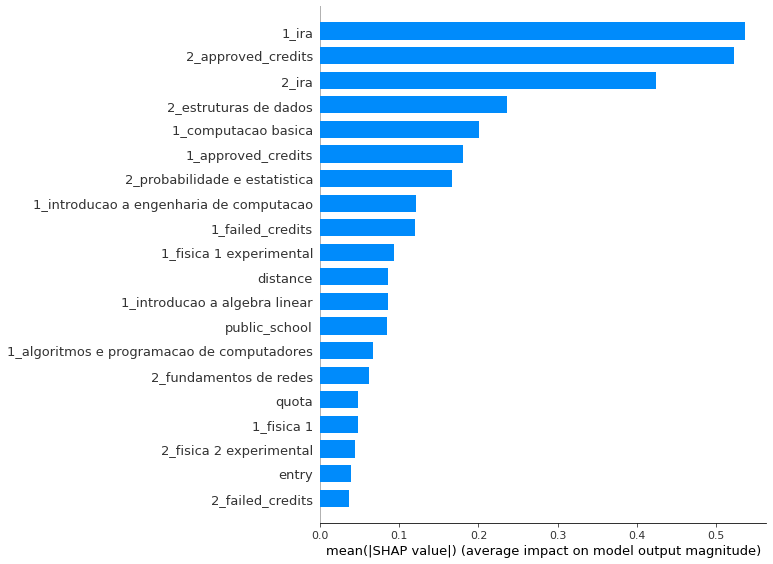

In [13]:
course = 'engenharia de computação'
model, X_test = catboost(data_process[course])

## Using SHAP

In [ ]:
explainer = shap.TreeExplainer(model)
start_index = 0
end_index = len(X_test)
shap_values = explainer.shap_values(X_test[start_index:end_index])

shap.initjs()

In [ ]:
id = 34
shap.force_plot(explainer.expected_value,
                shap_values[id:id+1],
                X_test[id:id+1])

In [ ]:
shap.force_plot(explainer.expected_value,
                shap_values,
                X_test[start_index:end_index])

In [ ]:
shap.summary_plot(shap_values, X_test[start_index:end_index], plot_size=(20,20), max_display=50)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=50)

In [ ]:
shap.dependence_plot('1_fisica 1', shap_values, X_test[start_index:end_index], interaction_index='distance')

## Plot Student's House Coordinates

In [ ]:
attr = ['aluno', 'cep', 'dropout', 'course']
# keys = data_analysis.keys()
keys = ['ciência da computação']
for course in keys:
    data = data_analysis[course].copy()[attr].drop_duplicates()
    utils.plot_coordinates(data, course)
#     utils.plot_coordinates_density(data, course)